### PeasY 21 (Python Easy 21 - or just easy peasy lemon squeezy)

We need a couple of functions for drawing cards:

In [1]:
import numpy as np

def drawCard():
    return np.random.randint(1,11)

def pickCol():
    if np.random.uniform() < 1/3:
        col = -1
    else:
        col = +1
    return col

In my implementation the state is represented by a pair, the dealer's first card and player's sum, so initially both draw a single card using drawCard() which is by default Black (+ve), and so the initial state is

s = [drawCard(), drawCard()]

There are only two actions for the player to pick from: "Hit" (a = 0) and "Stick" (a = 1)

When the player asks for a "Hit", then we only need to update s[0] by adding to it drawCard() $\times$ pickCol()
and as long as our sum is between 1 and 21 we can continue the game.

However, if our player choosed to "Stick", then we must let the dealer play out his game (fixed policy), and return the reward, as follows:

In [2]:
def playoutDealer(s):
    if (s[0] > 21) | (s[0] < 1):
        return -1.0
    while s[1] < 17:
        s[1] = s[1] + drawCard() * pickCol()
        if (s[1] > 21) | (s[1] < 1):
            return 1.0
    if s[1] > s[0]:
        return -1.0
    if s[0] > s[1]:
        return 1.0
    return 0.0

### Implementation of Q-learning

We now complete the implementation of the game and add during game play $Q-$learning to establish the optimal action-value function in the form of a table called $Q$ which is a 3D matrix taking in the arguments (playerSum, dealerCard, action):

In [3]:
Qoptimal = np.zeros((22,11,2)) 

You were not asked for $Q-$learning, however, $Q-$learning will give you the optimal action-value function. We will first need to implement a softmax policy, say the $\epsilon$-greedy:

In [4]:
def epsGreedy(epsilon, Q, s):
    action = np.array([0,1])
    if np.random.uniform() < epsilon:
        return action[np.random.randint(0,2)]
    return action[np.argmax(Q[s[0],s[1],:])]

In [5]:
def playEasy21Qlearning(Q, N):
    gamma = 1.0
    N0 = 100.0
    dealerCard = drawCard()
    playerCard = drawCard()
    s = [playerCard, dealerCard]
    epsilon = N0/(N0 + N[s[0],s[1],:].sum())
    a = epsGreedy(epsilon, Q, s)
    N[s[0],s[1],a] += 1
    while a == 0:
        card = drawCard() * pickCol()
        snew = [s[0]+card, s[1]]
        if (snew[0] > 21) | (snew[0] < 1):
            break
        epsilon = N0/(N0 + N[snew[0],snew[1],:].sum())
        anew = epsGreedy(epsilon, Q, snew)
        Q[s[0],s[1],a] = Q[s[0],s[1],a] + (1/N[s[0],s[1],a])*(0 + Q[snew[0],snew[1],:].max() - Q[s[0],s[1],a])
        s = snew
        a = anew
        N[s[0],s[1],a] += 1
    r = playoutDealer(np.copy(s))
    Q[s[0],s[1],a] = Q[s[0],s[1],a] + (1/N[s[0],s[1],a])*(r + 0 - Q[s[0],s[1],a])

We will use the same annealing scheme for $\epsilon$ as specified by the assigment for the MC and SARSA experiments, for this reason we need to count how often we visit state s and take action a, variable N[,,] keeps this value. You will notice that within the while loop the reward is zero and only when exiting the loop (game over) then can we figure out the outcome of the game (playoutDealer(s))

In [6]:
N = np.zeros((22,11,2))
for episode in range(100000):
    playEasy21Qlearning(Qoptimal, N)

Now lets take a look at the value function, the value function is the max over actions for the action-value function:

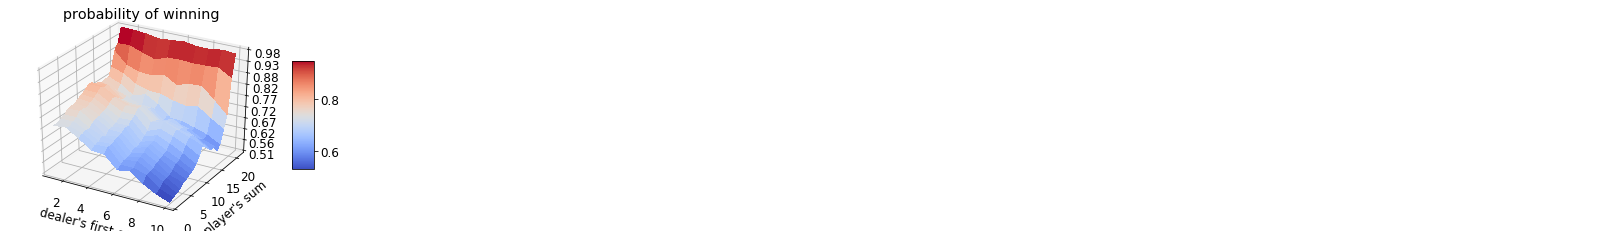

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

plt.rcParams.update({'font.size': 12})
ax = plt.gca(projection = '3d')
P, D = np.meshgrid(range(11), range(22))
V = np.max(Qoptimal, axis = 2) # these are expected values between -1 and 1, the probabilities are more meaningful:
Vprob = (V+1)/2
plt.ylabel("player's sum")
plt.xlabel("dealer's first card")
plt.title("probability of winning")
surf = ax.plot_surface(P[1:,1:], D[1:,1:], Vprob[1:,1:], cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.colorbar(surf, shrink = 0.5, aspect = 5)

It would also be interesting to see what he actions are for the different states:

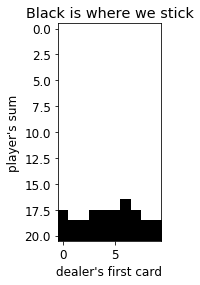

In [9]:
A = np.argmax(Qoptimal, axis = 2)
plt.ylabel("player's sum")
plt.xlabel("dealer's first card")
plt.title("Black is where we stick")
plt.imshow(1-A[1:,1:], cmap="gray")


The result is somewhat similar to the Blackjack example, however, there is no drop in value when the dealer is showing "1" (the Ace), which has a special meaning in Blackjack and not here. The results here will vary. The annealing of the steps size $\alpha$ and exloration $\epsilon$ are critical here. In general the strategy seems to be to stick once you are over 16.

### MC  and SARSA experiment

We are now ready to do some experiments, in my solution I decided to use the $Q-$learning to solve for the optimal state action value. Furthermore, MC is equivalent to SARSA(1) and so it is uncluded in the SARSA($\lambda$) function and so also in the experiments. We now define SARSA($\lambda$):

In [10]:
def playEasy21sarsa(Q, N, lam):
    gamma = 1.0
    N0 = 100.0
    E = np.zeros((22,11,2))
    dealerCard = drawCard()
    playerCard = drawCard()
    s = [playerCard, dealerCard]
    epsilon = N0/(N0 + N[s[0],s[1],:].sum())
    a = epsGreedy(epsilon, Q, s)
    N[s[0],s[1],a] += 1
    while a == 0:
        card = drawCard() * pickCol()
        snew = [s[0]+card, s[1]]
        if (snew[0] > 21) | (snew[0] < 1):
            break
        epsilon = N0/(N0 + N[snew[0],snew[1],:].sum())
        anew = epsGreedy(epsilon, Q, snew)
        delta = 0 + gamma * Q[snew[0],snew[1],anew] - Q[s[0],s[1],a]
        E[s[0],s[1],a] += 1
        Q[E > 0] = Q[E > 0] + delta * E[E > 0] * (1/N[E > 0])
        E = gamma * lam * E       
        s = snew
        a = anew
        N[s[0],s[1],a] += 1
    r = playoutDealer(np.copy(s))
    delta = r + gamma * 0 - Q[s[0],s[1],a]
    E[s[0],s[1],a] +=  1
    Q[E > 0] = Q[E > 0] + delta * E[E > 0] * (1/N[E > 0])

In the code above we have used the elilgibiliy traces to tell us what states have been visited during the episode, that is [E>0]. As an alternative one could have recorded all state and actions visited using another list variable. For example, SA = [], and then SA.append((s,a)). Now we perform all the experiments:

In [11]:
def experiment(lam):   
    mse = np.zeros((lam.size,1000))
    for k in range(lam.size):
        Q = np.zeros((22,11,2))
        N = np.zeros((22,11,2))
        for j in range(1000):
            for i in range(1):
                playEasy21sarsa(Q, N, lam[k])
            squares = (Qoptimal[1:,1:,:] - Q[1:,1:,:])**2
            mse[k,j] = squares.mean()
    return mse

and we do this for different $\lambda$ settings:

In [12]:
lam = np.array([0.0,0.2,0.4,0.6,0.8,1.0])
# to get a smoother results we should repeat our experiments:
n = 10
mse = experiment(lam)
for repeat in range(n-1):
    mse += experiment(lam)
mse = mse / n

Lets plot the convergence for the extreme cases MC/SARSA(1) versus SARSA(0) and actually lets just plot them for all $\lambda$s.

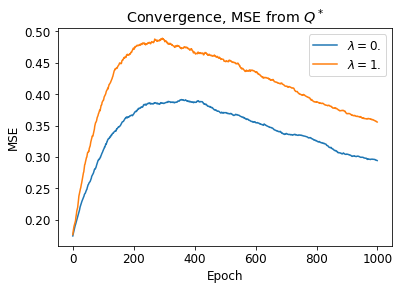

In [13]:
plt.title("Convergence, MSE from $Q^*$")
plt.xlabel("Epoch")
plt.ylabel("MSE")
for i in np.array([0,len(lam)-1]):
    plt.plot(range(1000),mse[i,:], label = "$\lambda=$" + np.array2string(lam[i]))
plt.legend(loc='upper right')

From this we see that $\lambda=0$ is better than MC ($\lambda=1$), but which $\lambda$ is best in terms of MSE after 1000 epochs ?!

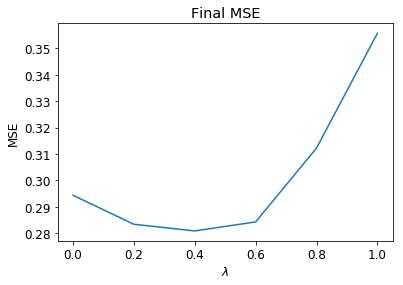

In [14]:
plt.title("Final MSE")
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.plot(lam,mse[:,-1])

The results here may vary, to get a reliable result you would need to replicate this experiment many times (here n=10) and take the average. This result is that $\lambda=0.4$ after 1000 epochs is best.